<a href="https://colab.research.google.com/github/sanket-srivastwa/Truth-vs-Hype/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing

In [ ]:
def load_packages():
  import subprocess
  requirement_file_path = '/content/drive/My Drive/requirement.txt'

  # ✅ Read and execute the code from the file
  try:
      with open(requirement_file_path, 'r') as f:
          lines = f.readlines()

      for line in lines:
          stripped = line.strip()
          if not stripped or stripped.startswith('#'):
              continue
          elif stripped.startswith('!pip'):
              # Convert !pip command to subprocess call
              cmd = stripped.lstrip('!').split()
              print(f"📦 Installing via pip: {' '.join(cmd)}")
              subprocess.check_call(cmd)
          elif stripped.startswith('nltk.download'):
              # Safe to execute nltk.download lines
              exec(stripped, globals())
          else:
              # Execute regular Python import or code lines
              exec(stripped, globals())

      print("✅ All lines executed successfully.")

  except Exception as e:
      print("❌ Failed to execute requirements:", e)


In [ ]:
def load_op_spam_dataset(root_dir):
    """
    Loads the op_spam_1.4 dataset into a pandas DataFrame.

    Parameters:
        root_dir (str): Path to the root directory of the dataset.

    Returns:
        pd.DataFrame: A DataFrame with columns: 'deceptive', 'polarity', and 'text'
    """
    data = []

    for polarity_folder in os.listdir(root_dir):
        polarity_path = os.path.join(root_dir, polarity_folder)
        if not os.path.isdir(polarity_path):
            continue

        polarity = 'positive' if 'positive' in polarity_folder.lower() else 'negative'

        for deception_folder in os.listdir(polarity_path):
            deception_path = os.path.join(polarity_path, deception_folder)
            if not os.path.isdir(deception_path):
                continue

            deceptive = 'deceptive' if 'deceptive' in deception_folder.lower() else 'truthful'

            for fold in os.listdir(deception_path):
                fold_path = os.path.join(deception_path, fold)
                if not os.path.isdir(fold_path):
                    continue

                for file_name in os.listdir(fold_path):
                    file_path = os.path.join(fold_path, file_name)
                    if os.path.isfile(file_path) and file_name.endswith('.txt'):
                        with open(file_path, 'r', encoding='utf-8') as file:
                            text = file.read().strip()
                            data.append({
                                'Opinion': deceptive,
                                'Polarity': polarity,
                                'Review': text
                            })

    return pd.DataFrame(data)

In [ ]:
def load_file(root_dir):
  df = load_op_spam_dataset(root_dir)
  print("The length of the dataframe is : ", len(df))
  display(df)
  return df

In [ ]:
def basic_checks(df):
  print("dataset info : ", df.info())
  missing_values = df.isnull().sum()
  print(missing_values)
  # Summary statistics
  summary_stats = df.describe()
  print("Summary statistics : ", summary_stats)
  # To find all occurrences of duplicate values (including the first),
  # set keep=False in the duplicated() method.
  all_duplicate_occurrences = df[df.duplicated(keep=False)]
  print("\nAll Occurrences of Duplicate Rows:")
  print(all_duplicate_occurrences)
  # Drop the duplicated row from the dataset
  df.drop_duplicates(inplace=True)
  print("The length of the datafrane is : ", len(df))
  text_length = df['Review'].apply(len)
  print("text_length is : ", text_length)

In [ ]:
def copy_dataframe(df):
  df_ori = df.copy()
  print("Opinion value counts:") #Show unique values with counts
  print(df['Opinion'].value_counts())

  print("\nPolarity value counts:")
  print(df['Polarity'].value_counts())

  print("Opinion value counts:") #Show unique values with counts
  print(df_ori['Opinion'].value_counts())

  print("\nPolarity value counts:")
  print(df_ori['Polarity'].value_counts())
  return df_ori

In [ ]:
def group(df):
  df = df.groupby(['Opinion', 'Polarity'])['Review'].agg(list)
  df = df.reset_index()
  return df

In [ ]:
def box_plot(df, column):
  # Add a column with the length of the text
  df["text_length"] = df[column].apply(len)

  # Pivot data: rows = opinion, columns = polarity
  pivot_df = df.pivot(index="Opinion", columns="Polarity", values="text_length")

  # Plotting
  pivot_df = pivot_df.sort_index()  # Ensure consistent order
  x = np.arange(len(pivot_df.index))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(8, 6))
  bars1 = ax.bar(x - width/2, pivot_df["negative"], width, label='Negative', color='salmon')
  bars2 = ax.bar(x + width/2, pivot_df["positive"], width, label='Positive', color='skyblue')

  # Labels and title
  ax.set_xlabel('deceptive and truthful')
  ax.set_ylabel('Text Length')
  ax.set_title('Text Length by Opinion and Polarity')
  ax.set_xticks(x)
  ax.set_xticklabels(pivot_df.index)
  ax.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def drop_column(df, col):
  df = df.drop(col, axis=1)
  return df

In [ ]:
# Convert the list column to string representation
def convert_to_str(df):
  df['Review_String'] = df['Review'].apply(lambda x: ', '.join(map(str, x)))
  return df

In [ ]:
# List of categorical features
def plot_variables(df):
  categorical_features = ['Opinion', 'Polarity']

  # Plotting bar charts for categorical features
  plt.figure(figsize=(20, 20))
  for i, feature in enumerate(categorical_features, 1):
      plt.subplot(3, 3, i)
      sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
      plt.title(f'Distribution of {feature}')
      plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

# NLP

In [ ]:
def get_wordnet_pos(treebank_tag):
    '''
    Get WordNet Part-of-Speech tagging
    Args:
        treebank_tag (str): string of detailed part-of-speech abbreviation
    Returns:
        Wordnet part-of-speech object grouping low-level part-of-speech to a higher level
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize(words):
    lemmatized_words = []
    lm = WordNetLemmatizer()
    tokens = nltk.word_tokenize(words)
    for word, pos in nltk.pos_tag(tokens):
        lm_pos = get_wordnet_pos(pos)
        lemmatized_words.append(lm.lemmatize(word, lm_pos))
    return lemmatized_words


def remove_stopwords(words):
    stop_words = stopwords.words('english')
    stop_words.extend(['chicago', 'hotel', 'would', 'could', 'should', 'might', 'room', 'stay'])
    result = [word for word in words if word not in stop_words]
    return result

In [ ]:
def preprocess_ngram(df, col):
    '''
    Returns
        df_pp (pd.DataFrame): DataFrame containing the same data as input, but add 3 columns
            1. Clean_Review (str): cleaned review texts
            2. After_Review (str): cleaned review text with stopwords removed
            3. Word_List (list): list of token containing cleaned reviews with stopwords removed
    '''
    df_pp = df.copy()
    clean_review = df_pp[col].copy()
    clean_review = clean_review.apply(lambda x: x.lower())
    clean_review = clean_review.apply(lambda x: re.sub('[,/.!?]', '', x))
    clean_review = clean_review.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    words = clean_review.apply(lambda x: lemmatize(x))
    df_pp['Clean_Review'] = words.apply(lambda x: ' '.join(x))
    words = words.apply(lambda x: remove_stopwords(x))
    df_pp['After_Review'] = words.apply(lambda x: ' '.join(x))
    df_pp['Word_List'] = words
    df_pp = df_pp.reset_index(drop=True)
    return df_pp

In [ ]:
def feature_engineering(df):
    '''
    Returns:
        df_new (pd.DataFrame): dataframe containing the data ss input df and additional linguistic feature columns
            - num_word: number of words in the review
            - num_coreword: number of core words in the review
            - num_stopword: number of stop words in the review
    '''
    df_new = df.copy()
    words = df_new['Clean_Review'].apply(lambda x: x.split())
    df_new['Num_Word'] = words.apply(len)
    df_new['Num_Coreword'] = df_new['Word_List'].apply(len)
    df_new['Num_Stopword'] = df_new['Num_Word'] - df_new['Num_Coreword']
    return df_new

In [ ]:
def bar_plot(df):
  # Group by polarity and calculate average num_stopword
  grouped = df.groupby("Polarity")["Num_Stopword"].mean().reset_index()

  # Bar plot
  plt.figure(figsize=(6, 4))
  bars = plt.bar(grouped["Polarity"], grouped["Num_Stopword"], color=["red", "green"])

  # Annotate bars
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2.0, yval + 500, int(yval), ha='center', va='bottom')

  # Labels and title
  plt.xlabel("Polarity")
  plt.ylabel("Average Stopword Count")
  plt.title("Average Stopword Count by Polarity")
  plt.tight_layout()
  plt.show()

In [ ]:
def cor(df):
  from collections import OrderedDict
  from sklearn.preprocessing import LabelEncoder
  from textblob import TextBlob

  # Label encoding for 'Opinion' and 'Polarity'
  le_opinion = LabelEncoder()
  le_polarity = LabelEncoder()

  df['Opinion_numeric'] = le_opinion.fit_transform(df['Opinion'])
  df['Polarity_numeric'] = le_polarity.fit_transform(df['Polarity'])

  # Extracting sentiment from 'Review' using TextBlob
  df['Review_length'] = df['Review'].apply(len)  # Length of the review
  # Extracting sentiment from 'Review' using TextBlob
  df['Review_sentiment'] = df['Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)  # Ensure 'x' is a string

  # Check the output
  print(df[['Review', 'Review_sentiment']].head())


  # Round the correlation matrix to 2 decimal places
  correlation_matrix = df[['Opinion_numeric', 'Polarity_numeric', 'Review_length', 'Review_sentiment']].corr().round(2)

  # Print the rounded correlation matrix
  print(correlation_matrix)

  # Plot a heatmap for better visualization
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
  plt.title('Correlation Matrix of Features')
  plt.show()


  print(correlation_matrix)

In [ ]:
def word_cloud(df):
  all_words = ' '.join(df['After_Review']).split()
  word_counts = Counter(all_words)
  print("Top 20 most common words:")
  print(word_counts.most_common(20))
  # Get the top 20 most common words
  top_20_words = dict(word_counts.most_common(20))

  # Create a WordCloud object using the top 20 words
  wordcloud = WordCloud(width=800, height=400, background_color='white')

  # Generate the word cloud from top 20 word frequencies
  wordcloud.generate_from_frequencies(top_20_words)

  # Display the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # Hide axis lines
  plt.title("Top 20 Most Common Words - Word Cloud")
  plt.show()

In [ ]:
def top_20(df):
  # Function to get top 20 words for After_Review by deceptive & polarity
  def get_top_words_by_group(df, text_column):
      top_words = {}
      groups = df.groupby(['Opinion', 'Polarity'])

      for (deceptive, polarity), group in groups:
          text = ' '.join(group[text_column].astype(str)).lower().split()
          word_freq = Counter(text)
          common_words = word_freq.most_common(20)
          top_words[(deceptive, polarity)] = common_words

      return top_words

  # Get word frequency per group
  top_after = get_top_words_by_group(df, 'After_Review')

  # Plot: Separate readable plots per group
  for (deceptive, polarity), word_data in top_after.items():
      words, freqs = zip(*word_data)

      plt.figure(figsize=(10, 6))
      sns.barplot(x=freqs, y=words, palette="coolwarm")

      plt.title(f"Top 20 Words in 'After_Review'\n({deceptive.capitalize()}, {polarity.capitalize()})", fontsize=14)
      plt.xlabel("Frequency", fontsize=12)
      plt.ylabel("Words", fontsize=12)
      plt.xticks(fontsize=10)
      plt.yticks(fontsize=10)
      plt.tight_layout()
      plt.show()

In [ ]:
def plot_20(df):
  all_lemmatized_text = ' '.join(df['After_Review'])
  # Tokenize
  tokens = nltk.word_tokenize(all_lemmatized_text)

  # Create bigrams
  bigrams = list(ngrams(tokens, 2))

  # Count top 40 bigrams
  bigram_counts = Counter(bigrams)
  top_40_bigrams = bigram_counts.most_common(40)

  # Display results
  print("Top 40 Most Common Lemmatized Bigrams:")
  for bigram, count in top_40_bigrams:
      print(f"{bigram[0]} {bigram[1]}: {count}")
  bigram_labels = [' '.join(b) for b, _ in top_40_bigrams]
  bigram_values = [count for _, count in top_40_bigrams]

  plt.figure(figsize=(12, 10))
  sns.barplot(x=bigram_values, y=bigram_labels, palette='coolwarm')
  plt.title("Top 40 Lemmatized Bigrams in Reviews")
  plt.xlabel("Frequency")
  plt.ylabel("Bigrams")
  plt.show()

  df_melted = df.melt(id_vars=["Opinion", "Polarity"],
                    value_vars=["Num_Word", "Num_Coreword", "Num_Stopword"],
                    var_name="Metric", value_name="Count")

  plt.figure(figsize=(10, 6))
  sns.barplot(data=df_melted, x="Opinion", y="Count", hue="Metric", palette="Set2", ci=None,
              estimator=sum, dodge=True)
  plt.title("Word Metrics by opinion")
  plt.tight_layout()
  plt.show()

# ML - Naive Bayes

In [ ]:
def ml_nb_model(df_ori):
    df = df_ori.copy()
    drive_path = '/content/drive/My Drive/pkl folder/'
    # ----------------- INDEPENDENT LABELS -----------------
    print("\n=== Independent Opinion and Polarity Classification ===\n")
    X = df['Review']
    y = df[['Opinion', 'Polarity']]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), stop_words='english')
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    joblib.dump(tfidf, drive_path+'nb_tfidf_vectorizer.pkl')

    param_grid_nb = {
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    base_nb = MultinomialNB()
    multi_nb = MultiOutputClassifier(base_nb)

    grid_nb = GridSearchCV(multi_nb, param_grid_nb, cv=5, scoring='accuracy', verbose=1)
    grid_nb.fit(X_train_tfidf, y_train)

    best_nb_model = grid_nb.best_estimator_
    joblib.dump(best_nb_model, drive_path+'multi_nb_model.pkl')

    predictions = best_nb_model.predict(X_test_tfidf)

    pred_df = pd.DataFrame(predictions, columns=['Predicted Opinion', 'Predicted Polarity'])
    predicted_reviews = pd.DataFrame({
        'Review': X_test.reset_index(drop=True),
        'Predicted Opinion': pred_df['Predicted Opinion'],
        'Predicted Polarity': pred_df['Predicted Polarity']
    })
    display(predicted_reviews.head())

    opinion_acc = accuracy_score(y_test['Opinion'], predictions[:, 0])
    polarity_acc = accuracy_score(y_test['Polarity'], predictions[:, 1])
    print("Accuracy (Opinion):", opinion_acc)
    print("Accuracy (Polarity):", polarity_acc)

    conf_opinion = confusion_matrix(y_test['Opinion'], predictions[:, 0])
    conf_polarity = confusion_matrix(y_test['Polarity'], predictions[:, 1])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(conf_opinion, annot=True, fmt='d',
                xticklabels=sorted(y_test['Opinion'].unique()),
                yticklabels=sorted(y_test['Opinion'].unique()),
                cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix: Opinion')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(conf_polarity, annot=True, fmt='d',
                xticklabels=sorted(y_test['Polarity'].unique()),
                yticklabels=sorted(y_test['Polarity'].unique()),
                cmap='Greens', ax=axes[1])
    axes[1].set_title('Confusion Matrix: Polarity')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ----------------- COMBINED LABEL -----------------
    print("\n=== Combined Opinion+Polarity Classification ===\n")
    df['Label'] = df['Opinion'] + '_' + df['Polarity']
    X = df['Review']
    y = df['Label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('nb', MultinomialNB())
    ])

    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 3, 5],
        'nb__alpha': [0.1, 0.5, 1.0]
    }

    grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    model_name = drive_path+'combined_nb_model.pkl'
    joblib.dump(grid.best_estimator_, model_name)

    # Save the combined label TF-IDF vectorizer
    combined_tfidf = grid.best_estimator_.named_steps['tfidf']
    tf_idf_model_name = drive_path+'combined_tfidf_vectorizer.pkl'
    joblib.dump(combined_tfidf, tf_idf_model_name)

    y_pred = grid.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print(f"Best Parameters: {grid.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=grid.classes_,
                yticklabels=grid.classes_,
                cmap='Blues')
    plt.title('Confusion Matrix Heatmap - Combined Label')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return {
        'model_name': 'ML-NB',
        'accuracy': accuracy,
        'model_file_name': model_name,
        'tf_idf_model_name': tf_idf_model_name
    }

# ML - TF-IDF (N-Gram) (LR)

In [ ]:
def ml_lr_model(df_ori):
    def plot_heatmap(y_true, y_pred, labels, title):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    df = df_ori.copy()
    drive_path = '/content/drive/My Drive/pkl folder/'
    # Encode Opinion and Polarity
    opinion_encoder = LabelEncoder()
    polarity_encoder = LabelEncoder()
    df['Opinion'] = opinion_encoder.fit_transform(df['Opinion'])
    df['Polarity'] = polarity_encoder.fit_transform(df['Polarity'])

    # ==== Multi-output (Separate Opinion and Polarity Prediction) ====
    X = df['Review']
    y_multi = df[['Opinion', 'Polarity']]
    X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

    pipeline_multi = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000)))
    ])

    param_grid_multi = {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__C': [0.1, 1, 10],
        'clf__estimator__solver': ['liblinear', 'saga']
    }

    grid_multi = GridSearchCV(pipeline_multi, param_grid_multi, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_multi.fit(X_train, y_train)
    print("\nBest Parameters (Multi-output):", grid_multi.best_params_)

    y_pred_multi = grid_multi.best_estimator_.predict(X_test)
    print("\n--- Multi-output Classification Reports ---")
    print("\nOpinion:")
    print(classification_report(y_test['Opinion'], y_pred_multi[:, 0], target_names=opinion_encoder.classes_))
    print("\nPolarity:")
    print(classification_report(y_test['Polarity'], y_pred_multi[:, 1], target_names=polarity_encoder.classes_))

    print("Accuracy (Opinion):", accuracy_score(y_test['Opinion'], y_pred_multi[:, 0]))
    print("Accuracy (Polarity):", accuracy_score(y_test['Polarity'], y_pred_multi[:, 1]))

    plot_heatmap(y_test['Opinion'], y_pred_multi[:, 0], opinion_encoder.classes_, "Heatmap - Opinion Prediction")
    plot_heatmap(y_test['Polarity'], y_pred_multi[:, 1], polarity_encoder.classes_, "Heatmap - Polarity Prediction")

    # ==== Combined Label Classification ====
    df['Combined_Label'] = df['Opinion'].astype(str) + "_" + df['Polarity'].astype(str)
    combined_encoder = LabelEncoder()
    df['Combined_Label'] = combined_encoder.fit_transform(df['Combined_Label'])

    X_comb = df['Review']
    y_comb = df['Combined_Label']
    X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_comb, y_comb, test_size=0.2, random_state=42)

    pipeline_comb = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    param_grid_comb = {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['liblinear', 'saga']
    }

    grid_comb = GridSearchCV(pipeline_comb, param_grid_comb, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_comb.fit(X_train_comb, y_train_comb)
    print("\nBest Parameters (Combined):", grid_comb.best_params_)
    model_name = drive_path+'combined_lr_model.pkl'
    joblib.dump(grid_comb.best_estimator_, model_name)
    y_pred_comb = grid_comb.best_estimator_.predict(X_test_comb)

    # Save the combined label TF-IDF vectorizer
    combined_tfidf = grid_comb.best_estimator_.named_steps['tfidf']
    tf_idf_model_name = drive_path+'lr_combined_tfidf_vectorizer.pkl'
    joblib.dump(combined_tfidf, tf_idf_model_name)

    print("\n--- Combined Label Classification Report ---")
    print(classification_report(y_test_comb, y_pred_comb, target_names=combined_encoder.classes_))
    accuracy = accuracy_score(y_test_comb, y_pred_comb)
    print("Accuracy (Combined Label):", accuracy)
    plot_heatmap(y_test_comb, y_pred_comb, combined_encoder.classes_, "Heatmap - Combined Label Prediction")
    return {
        'model_name': 'ML-LR',
        'accuracy': accuracy,
        'model_file_name': model_name,
        'tf_idf_model_name': tf_idf_model_name
    }

# SVM

In [ ]:
def ml_svm_model(df_ori):
    df = df_ori.copy()
    drive_path = '/content/drive/My Drive/pkl folder/'
    # ----------------- INDEPENDENT LABELS -----------------
    print("\n=== Independent Opinion and Polarity Classification (SVM) ===\n")
    X = df['Review']
    y = df[['Opinion', 'Polarity']]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), stop_words='english')
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    joblib.dump(tfidf, drive_path+'svm_tfidf_vectorizer.pkl')

    param_grid_svm = {
        'estimator__C': [0.01, 0.1, 1.0, 10.0],
        'estimator__loss': ['hinge', 'squared_hinge']
    }

    base_svm = LinearSVC(max_iter=5000)
    multi_svm = MultiOutputClassifier(base_svm)

    grid_svm = GridSearchCV(multi_svm, param_grid_svm, cv=5, scoring='accuracy', verbose=1)
    grid_svm.fit(X_train_tfidf, y_train)

    best_svm_model = grid_svm.best_estimator_
    joblib.dump(best_svm_model, drive_path+'multi_svm_model.pkl')

    predictions = best_svm_model.predict(X_test_tfidf)

    pred_df = pd.DataFrame(predictions, columns=['Predicted Opinion', 'Predicted Polarity'])
    predicted_reviews = pd.DataFrame({
        'Review': X_test.reset_index(drop=True),
        'Predicted Opinion': pred_df['Predicted Opinion'],
        'Predicted Polarity': pred_df['Predicted Polarity']
    })
    display(predicted_reviews.head())

    opinion_acc = accuracy_score(y_test['Opinion'], predictions[:, 0])
    polarity_acc = accuracy_score(y_test['Polarity'], predictions[:, 1])
    print("Accuracy (Opinion):", opinion_acc)
    print("Accuracy (Polarity):", polarity_acc)

    conf_opinion = confusion_matrix(y_test['Opinion'], predictions[:, 0])
    conf_polarity = confusion_matrix(y_test['Polarity'], predictions[:, 1])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(conf_opinion, annot=True, fmt='d',
                xticklabels=sorted(y_test['Opinion'].unique()),
                yticklabels=sorted(y_test['Opinion'].unique()),
                cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix: Opinion (SVM)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(conf_polarity, annot=True, fmt='d',
                xticklabels=sorted(y_test['Polarity'].unique()),
                yticklabels=sorted(y_test['Polarity'].unique()),
                cmap='Greens', ax=axes[1])
    axes[1].set_title('Confusion Matrix: Polarity (SVM)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ----------------- COMBINED LABEL -----------------
    print("\n=== Combined Opinion+Polarity Classification (SVM) ===\n")
    df['Label'] = df['Opinion'] + '_' + df['Polarity']
    X = df['Review']
    y = df['Label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('svm', LinearSVC(max_iter=5000))
    ])

    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 3],
        'svm__C': [0.1, 1, 10],
        'svm__loss': ['hinge', 'squared_hinge']
    }

    grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    model_name = drive_path+'combined_svm_model.pkl'
    joblib.dump(grid.best_estimator_, model_name)

    # Save the combined label TF-IDF vectorizer
    combined_tfidf = grid.best_estimator_.named_steps['tfidf']
    tf_idf_model_name = drive_path+'combined_svm_tfidf_vectorizer.pkl'
    joblib.dump(combined_tfidf, drive_path + 'combined_svm_tfidf_vectorizer.pkl')

    y_pred = grid.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print(f"Best Parameters: {grid.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=grid.classes_,
                yticklabels=grid.classes_,
                cmap='Blues')
    plt.title('Confusion Matrix Heatmap - Combined Label (SVM)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return {
        'model_name': 'ML-SVM',
        'accuracy': accuracy,
        'model_file_name': model_name,
        'tf_idf_model_name': tf_idf_model_name
    }

# CSV Prediction

In [ ]:
def predict_reviews_from_csv(csv_file, drive_path, best_model_info):
    import pandas as pd
    import joblib
    from datetime import datetime
    import os

    # Read input CSV
    df = pd.read_csv(csv_file)
    if 'Review' not in df.columns:
        raise ValueError("CSV must contain a 'Review' column.")

    # Load model
    model_path = os.path.join(drive_path, "best model", best_model_info['model_file_name'].rsplit('/', 1)[-1])
    model = joblib.load(model_path)

    # Manually recreate combined label encoder (based on training-time logic)
    # These are hardcoded based on your dataset logic
    combined_labels = [
        'truthful_negative', 'truthful_positive',
        'deceptive_negative', 'deceptive_positive'
    ]

    from sklearn.preprocessing import LabelEncoder
    combined_encoder = LabelEncoder()
    combined_encoder.fit(combined_labels)

    # Predict
    predictions = model.predict(df['Review'])  # these are integers like 0,1,2,3

    # Decode integer predictions back to combined string labels
    decoded_labels = combined_encoder.inverse_transform(predictions)

    # Split into separate columns
    opinion_list, polarity_list = zip(*[label.split("_") for label in decoded_labels])
    df['Predicted Opinion'] = opinion_list
    df['Predicted Polarity'] = polarity_list

    # Save output
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(drive_path, f'predicted_output_{timestamp}.csv')
    df.to_csv(output_path, index=False)
    print(f"✅ Predictions saved to: {output_path}")
    return output_path


In [ ]:
def prediction_validation(output_path):
  # Load your CSV file with actual and predicted columns
  df = pd.read_csv(output_path)

  # Check for mismatches
  mismatches = df[
      (df['Opinion'] != df['Predicted Opinion']) |
      (df['Polarity'] != df['Predicted Polarity'])
  ]

  # Show mismatched rows
  print("🔎 Mismatched rows:")
  print(mismatches)

  # Optionally save them
  mismatches.to_csv('mismatched_rows.csv', index=False)
  print(f"\nMismatches count: {len(mismatches)}")


# Streamlit

In [ ]:
%%writefile app.py

# app.py

import streamlit as st
import pandas as pd
import joblib
import os, sys
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from io import BytesIO

if len(sys.argv) > 1:
    argument = sys.argv[1]
else:
    print("No argument provided.")

# --- Config ---
drive_path = "/content/drive/My Drive/pkl folder/"
best_model_info = {
    'model_file_name': 'combined_lr_model.pkl',
    'tf_idf_model_name': 'lr_combined_tfidf_vectorizer.pkl'
}

# --- Load Model ---
@st.cache_resource
def load_model():
    model_path = os.path.join(drive_path, "best model", argument)
    model = joblib.load(model_path)

    # Rebuild encoder as in training
    combined_labels = [
        'truthful_negative', 'truthful_positive',
        'deceptive_negative', 'deceptive_positive'
    ]
    encoder = LabelEncoder()
    encoder.fit(combined_labels)
    return model, encoder

model, encoder = load_model()

# --- Predict Function ---
def predict(df, model, encoder):
    predictions = model.predict(df['Review'])
    decoded = encoder.inverse_transform(predictions)
    opinion_list, polarity_list = zip(*[x.split("_") for x in decoded])
    df['Predicted Opinion'] = opinion_list
    df['Predicted Polarity'] = polarity_list
    return df

# --- Streamlit UI ---
st.title("🧠 Review Opinion & Polarity Predictor")

uploaded_file = st.file_uploader("📤 Upload a CSV file with a 'Review' column", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)

    if 'Review' not in df.columns:
        st.error("CSV must contain a 'Review' column.")
    else:
        st.subheader("📋 Sample Input (Top 10 Rows)")
        st.dataframe(df.head(10))

        if st.button("🔮 Predict Opinion and Polarity"):
            result_df = predict(df.copy(), model, encoder)

            # Check for mismatches (only if actual Opinion/Polarity columns exist)
            mismatches = 0
            if 'Opinion' in result_df.columns and 'Polarity' in result_df.columns:
                mismatches = ((result_df['Opinion'].str.lower() != result_df['Predicted Opinion']) |
                              (result_df['Polarity'].str.lower() != result_df['Predicted Polarity'])).sum()
                st.info(f"⚠️ Mismatched Predictions: {mismatches}")

            st.subheader("✅ Predictions (Top 10 Rows)")
            st.dataframe(result_df.head(10))

            # Convert to downloadable CSV
            towrite = BytesIO()
            result_df.to_csv(towrite, index=False)
            towrite.seek(0)

            st.download_button(
                label="📥 Download Full Predictions CSV",
                data=towrite,
                file_name=f"predicted_reviews_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv",
                mime="text/csv"
            )

Overwriting app.py


# Main

In [ ]:
def main(root_dir, csv_file, drive_path, model=None):
  from google.colab import drive
  import os, sys
  import subprocess
  from collections import OrderedDict
  # Check if the mount point exists
  if not os.path.ismount('/content/drive'):
      drive.mount('/content/drive', force_remount=False)
  else:
      print("Google Drive is already mounted.")

  model = model.upper() if model else "ALL"
  #Loading packages
  load_packages()

  #EDA
  #Pre-processing
  print("--------------------")
  print("Loading Data")
  print("--------------------")
  df = load_file(root_dir)
  print("--------------------")
  print("Basics checks")
  print("--------------------")
  basic_checks(df)
  print("--------------------")
  print("Copying Data")
  print("--------------------")
  df_ori = copy_dataframe(df)
  print("--------------------")
  print("Grouping By")
  print("--------------------")
  df = group(df)
  print("--------------------")
  print("Box Plot")
  print("--------------------")
  box_plot(df, "Review")
  print("--------------------")
  print("Dropping column")
  print("--------------------")
  df = drop_column(df, 'text_length')
  text_length = df['Review'].apply(len)
  print(text_length)
  df = convert_to_str(df)
  plot_variables(df)
  #NLP
  df = preprocess_ngram(df, 'Review_String')
  df = feature_engineering(df)
  print("--------------------")
  print("Bar plot")
  print("--------------------")
  bar_plot(df)
  print("--------------------")
  print("Word Cloud")
  print("--------------------")
  word_cloud(df)
  print("--------------------")
  print("Correlation")
  print("--------------------")
  cor(df)
  print("--------------------")
  print("Top 20")
  print("--------------------")
  top_20(df)
  print("--------------------")
  print("Plot 20")
  print("--------------------")
  plot_20(df)

  results = []

  if model == 'NB':
    # ML-NB
    print("--------------------")
    print("Naive Bayes modeling operation in progress . . ")
    print("--------------------")
    results.append(ml_nb_model(df_ori))
    print("--------------------")
    print("Naive Bayes modeling operation done. ")
    print("--------------------")
  elif model == "LR":
    # ML-LR
    print("--------------------")
    print("Logistic Regression modeling operation in progress . . ")
    print("--------------------")
    results.append(ml_lr_model(df_ori))
    print("--------------------")
    print("Logistic Regression modeling operation done. ")
    print("--------------------")
  elif model == "SVM":
    # ML-SVM
    print("--------------------")
    print("SVM modeling operation in progress . . ")
    print("--------------------")
    results.append(ml_svm_model(df_ori))
    print("--------------------")
    print("SVM modeling operation done. ")
    print("--------------------")
  elif model == "ALL":
    print("--------------------")
    print("Naive Bayes modeling operation in progress . . ")
    print("--------------------")
    results.append(ml_nb_model(df_ori))
    print("--------------------")
    print("Naive Bayes modeling operation done. ")
    print("--------------------")
    print("--------------------")
    print("Logistic Regression modeling operation in progress . . ")
    print("--------------------")
    results.append(ml_lr_model(df_ori))
    print("--------------------")
    print("Logistic Regression modeling operation done. ")
    print("--------------------")
    print("--------------------")
    print("SVM modeling operation in progress . . ")
    print("--------------------")
    results.append(ml_svm_model(df_ori))
    print("--------------------")
    print("SVM modeling operation done. ")
    print("--------------------")
  else:
    print(f"Model is not operational currently. Please try without any model for the best response.")
    sys.exit("Please use NB, LR, SVM.")

  # Sort results by accuracy in descending order
  results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)
  print("\n====================")
  print("Results : ", results_sorted)
  print("====================")
  # Pick the best model
  best_model = results_sorted[0]

  print("\n====================")
  print("Best Model Summary")
  print("====================")
  print(f"Model Name: {best_model['model_name']}")
  print(f"Accuracy: {best_model['accuracy']:.4f}")
  print(f"Model File: {best_model['model_file_name']}")
  print(f"TF IDF Model File: {best_model['tf_idf_model_name']}")

  # Specify the destination folder where the best model should be moved
  destination_folder = f"{drive_path}/best model"

  # Create the destination folder if it doesn't exist
  os.makedirs(destination_folder, exist_ok=True)

  # Move the best model file
  best_model_file = best_model['model_file_name']
  shutil.move(best_model_file, os.path.join(destination_folder, os.path.basename(best_model_file)))

  # Move the corresponding TF-IDF vectorizer
  tfidf_file = best_model['tf_idf_model_name']
  shutil.move(tfidf_file, os.path.join(destination_folder, os.path.basename(tfidf_file)))

  print(f"✅ Moved best model and TF-IDF vectorizer to: {destination_folder}")

  output_path = predict_reviews_from_csv(csv_file, drive_path, best_model)

  prediction_validation(output_path)

  return best_model

In [ ]:
def run():
  !pip install -q streamlit
  !npm install -g localtunnel
  root_dir = '/content/drive/My Drive/Colab Notebooks/Deceptive_Opinion_Spam_Corpus_v1.4/op_spam_v1.4/'
  csv_file = '/content/drive/My Drive/sample_100_reviews.csv'
  drive_path='/content/drive/My Drive/pkl folder/'
  best_model = main(root_dir, csv_file, drive_path)
  model = best_model['model_file_name'].rsplit('/', 1)[-1]
  !streamlit run app.py {model} &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

# Run

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
changed 22 packages in 2s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


📦 Installing via pip: pip install wordcloud
✅ All lines executed successfully.
--------------------
Loading Data
--------------------
The length of the dataframe is :  1600


,Opinion,Polarity,Review
0,deceptive,positive,"My fiancee and I were looking for a modern, up..."
1,deceptive,positive,My wife and I spent our honeymoon in Chicago t...
2,deceptive,positive,This was my first time in Chicago and I tell y...
3,deceptive,positive,If you are traveling to Chicago and need a pla...
4,deceptive,positive,Hotel Allegro Chicago is a beautiful place. I ...
...,...,...,...
1595,deceptive,negative,Having traveled to Chicago on business once be...
1596,deceptive,negative,Upon entering my hotel room at The Palmer Hous...
1597,deceptive,negative,My stay at The Palmer House Hilton was less th...
1598,deceptive,negative,"The Palmer House Hilton, while it looks good i..."


--------------------
Basics checks
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Opinion   1600 non-null   object
 1   Polarity  1600 non-null   object
 2   Review    1600 non-null   object
dtypes: object(3)
memory usage: 37.6+ KB
dataset info :  None
Opinion     0
Polarity    0
Review      0
dtype: int64
Summary statistics :            Opinion  Polarity                                             Review
count        1600      1600                                               1600
unique          2         2                                               1596
top     deceptive  positive  My daughter and I woke in the morning wanting ...
freq          800       800                                                  2

All Occurrences of Duplicate Rows:
       Opinion  Polarity                                             Review
96

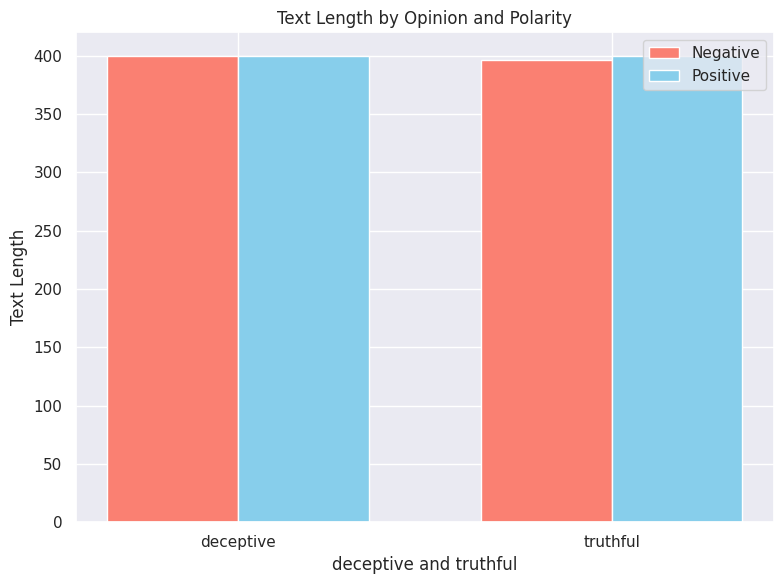

--------------------
Dropping column
--------------------
0    400
1    400
2    396
3    400
Name: Review, dtype: int64


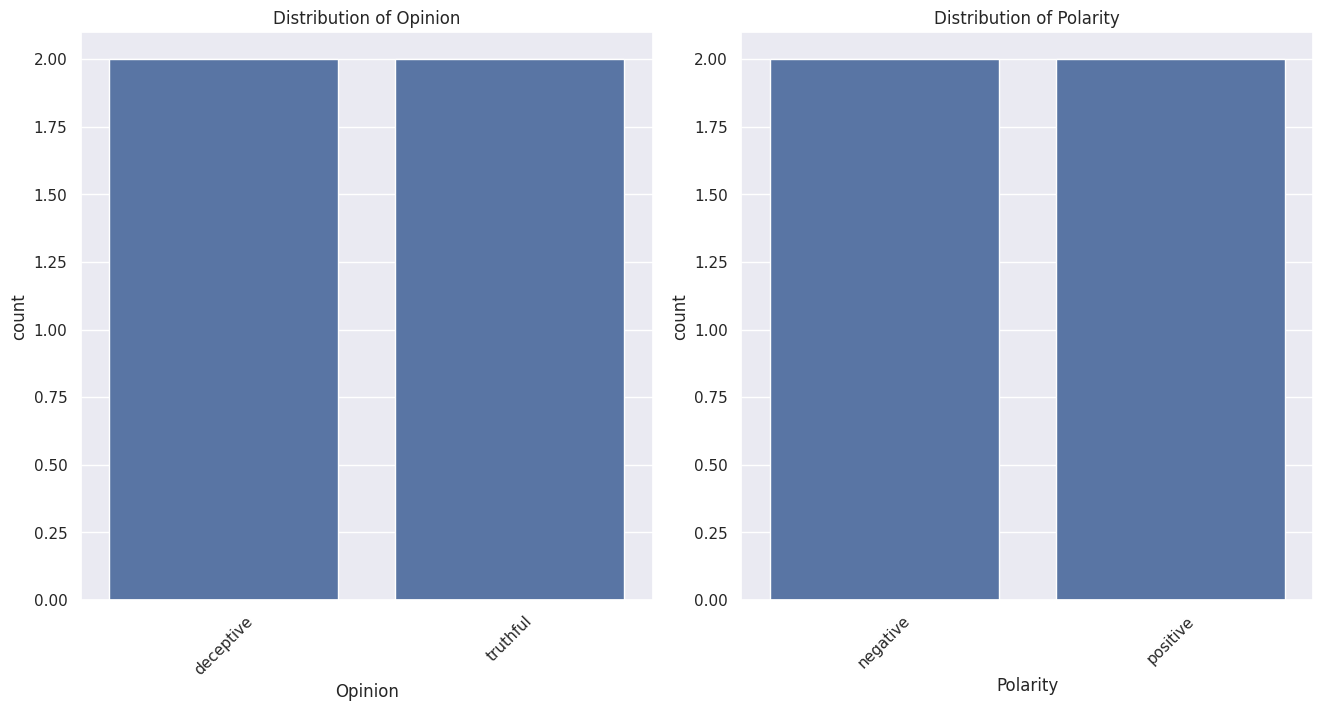

--------------------
Bar plot
--------------------


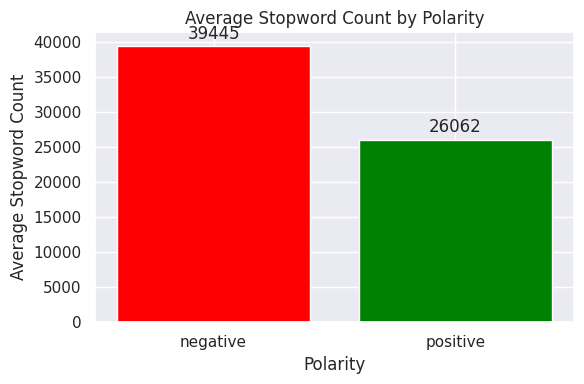

--------------------
Word Cloud
--------------------
Top 20 most common words:
[('get', 1028), ('great', 864), ('service', 856), ('staff', 840), ('go', 752), ('night', 723), ('one', 721), ('bed', 653), ('time', 619), ('make', 612), ('like', 598), ('good', 582), ('u', 577), ('clean', 512), ('nice', 508), ('desk', 502), ('location', 491), ('check', 486), ('even', 482), ('look', 468)]


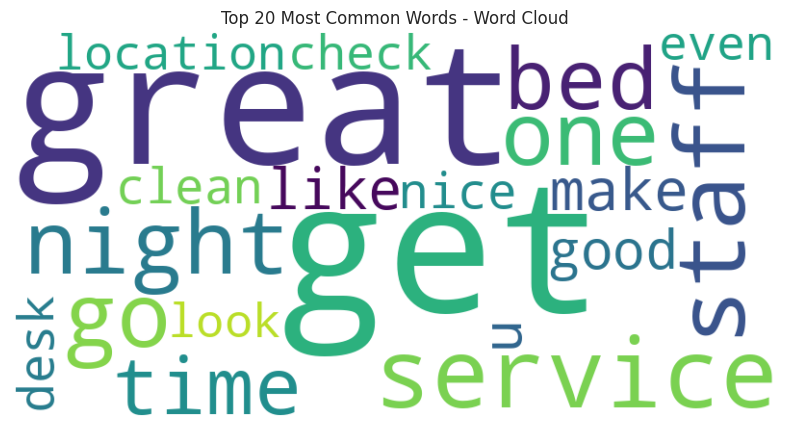

--------------------
Correlation
--------------------
                                              Review  Review_sentiment
0  [My husband and I recently stayed stayed at th...          0.023134
1  [My fiancee and I were looking for a modern, u...          0.362237
2  [This place had character I'll give it that. B...          0.068567
3  [went to chicago for a week in may, decided to...          0.323693
                  Opinion_numeric  Polarity_numeric  Review_length  \
Opinion_numeric              1.00              0.00          -0.58   
Polarity_numeric             0.00              1.00           0.58   
Review_length               -0.58              0.58           1.00   
Review_sentiment             0.01              0.99           0.48   

                  Review_sentiment  
Opinion_numeric               0.01  
Polarity_numeric              0.99  
Review_length                 0.48  
Review_sentiment              1.00  


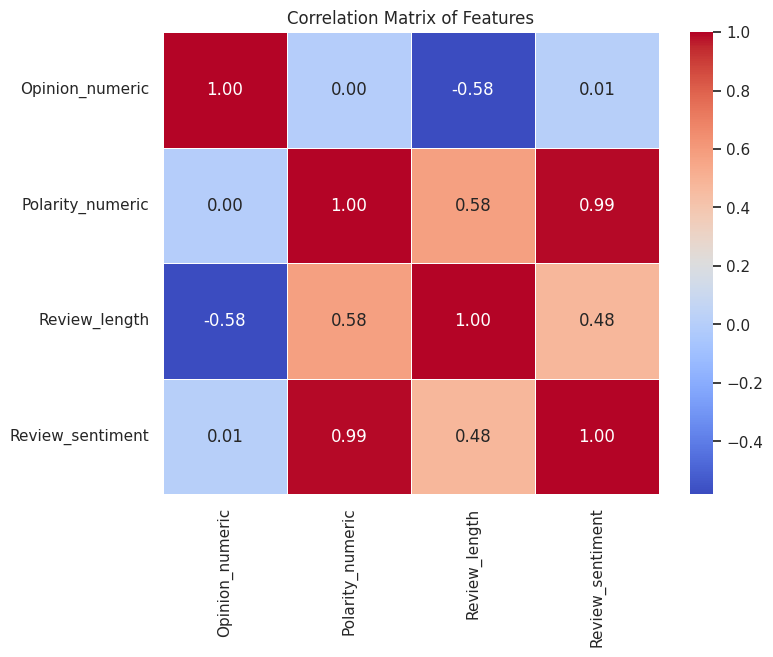

                  Opinion_numeric  Polarity_numeric  Review_length  \
Opinion_numeric              1.00              0.00          -0.58   
Polarity_numeric             0.00              1.00           0.58   
Review_length               -0.58              0.58           1.00   
Review_sentiment             0.01              0.99           0.48   

                  Review_sentiment  
Opinion_numeric               0.01  
Polarity_numeric              0.99  
Review_length                 0.48  
Review_sentiment              1.00  
--------------------
Top 20
--------------------


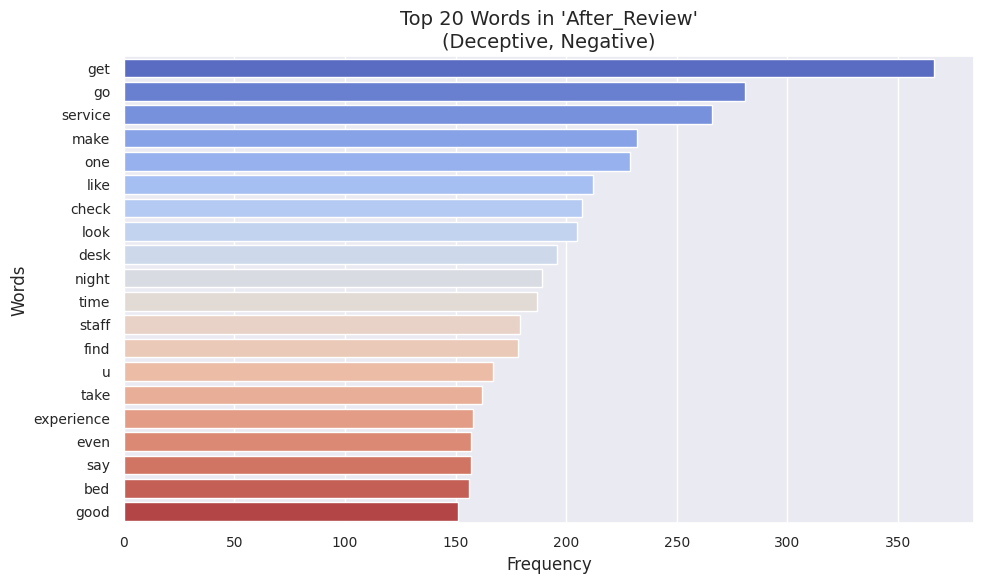

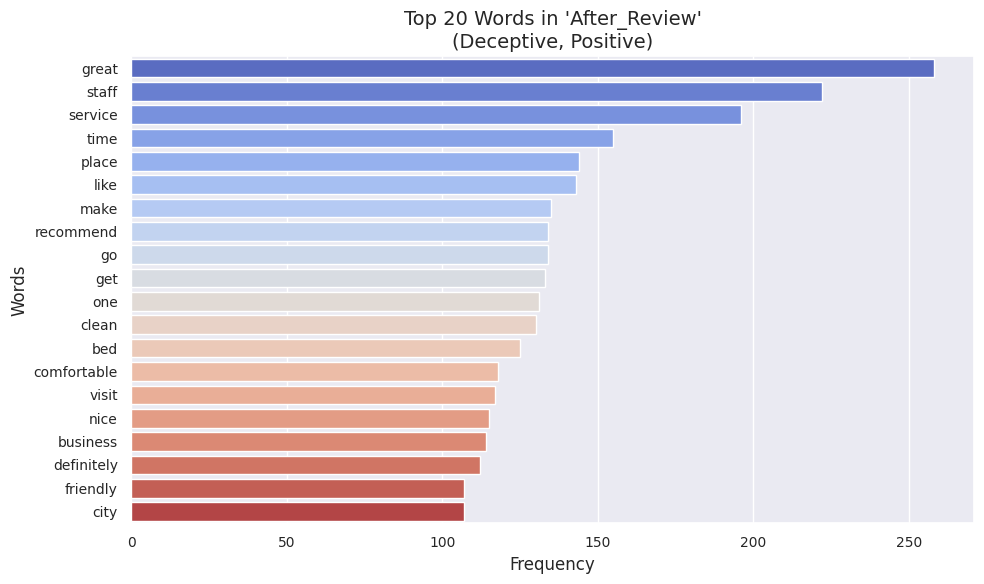

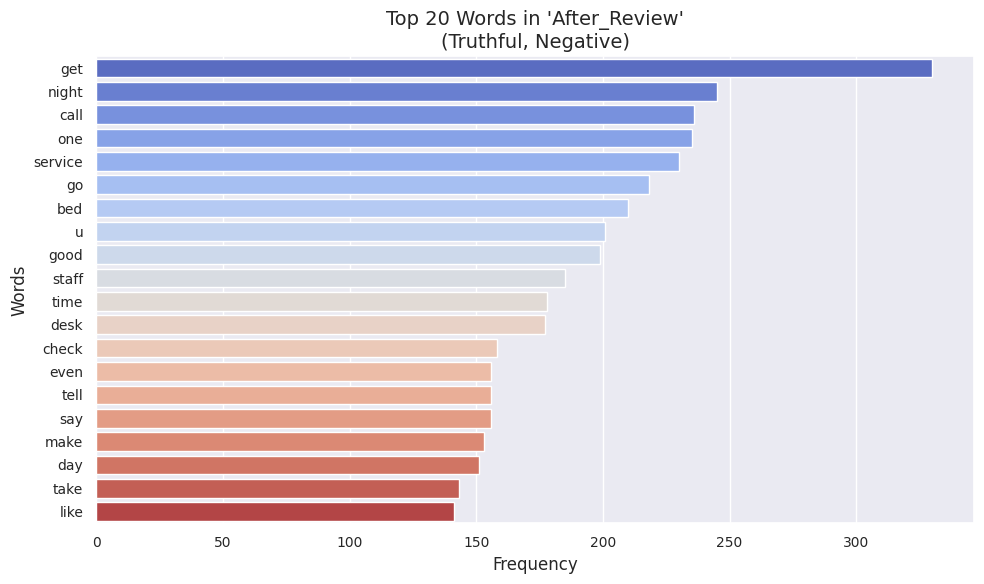

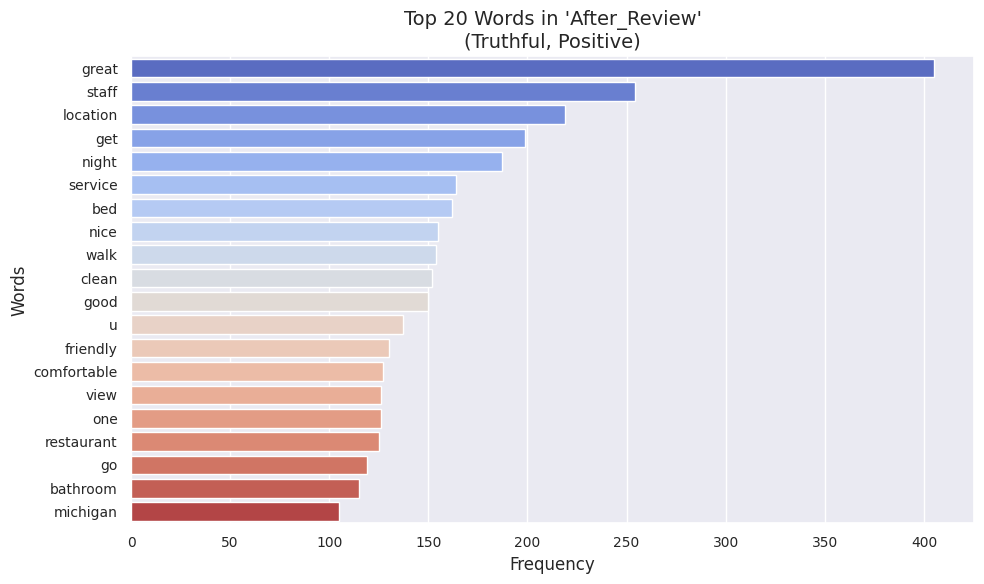

--------------------
Plot 20
--------------------
Top 40 Most Common Lemmatized Bigrams:
front desk: 335
customer service: 99
staff friendly: 98
hard rock: 97
go back: 96
highly recommend: 85
walk distance: 79
next time: 77
come back: 74
great location: 74
michigan ave: 74
look like: 73
bed comfortable: 72
recommend anyone: 69
ambassador east: 69
one night: 68
even though: 68
call front: 66
magnificent mile: 66
palmer house: 61
give u: 57
navy pier: 57
michigan avenue: 54
felt like: 53
great view: 53
friendly helpful: 52
desk staff: 50
look forward: 48
size bed: 48
make reservation: 48
fitness center: 48
business trip: 47
location great: 46
hyatt regency: 46
desk clerk: 45
finally get: 45
feel like: 45
water tower: 42
homewood suite: 42
two night: 41


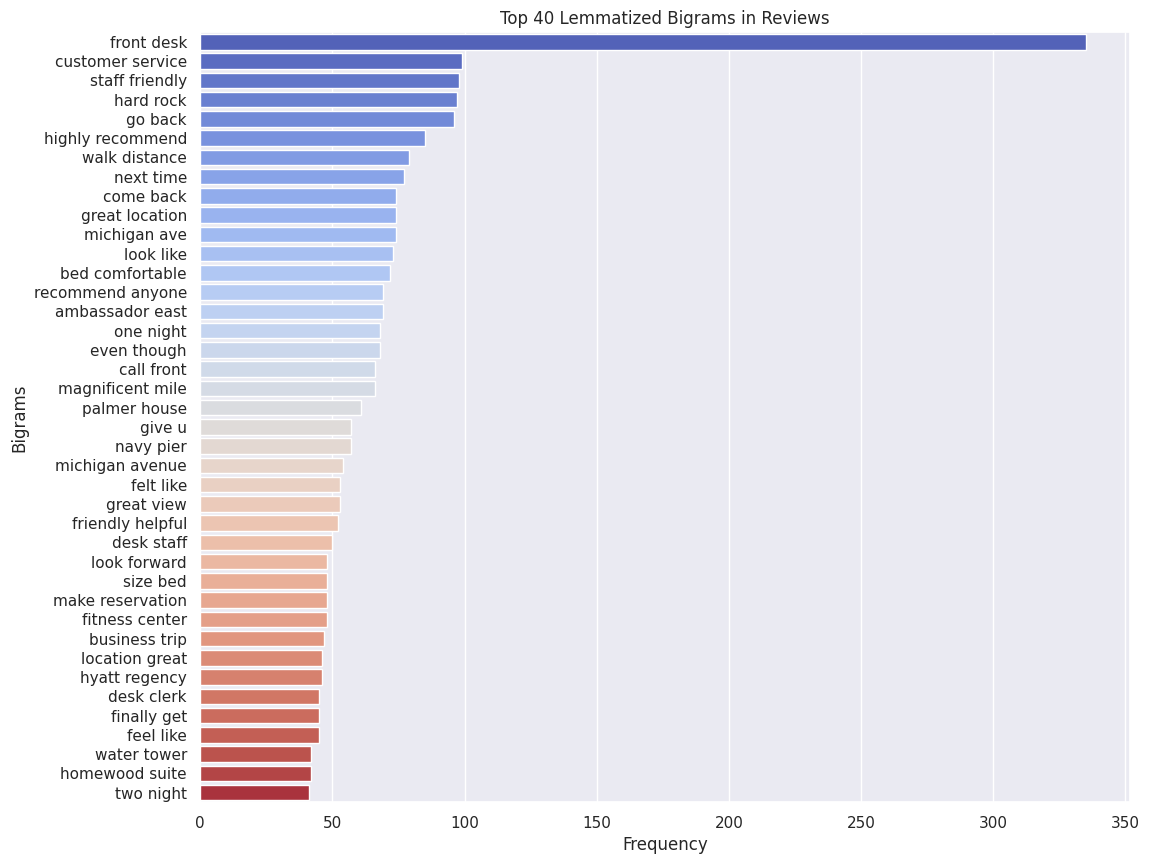

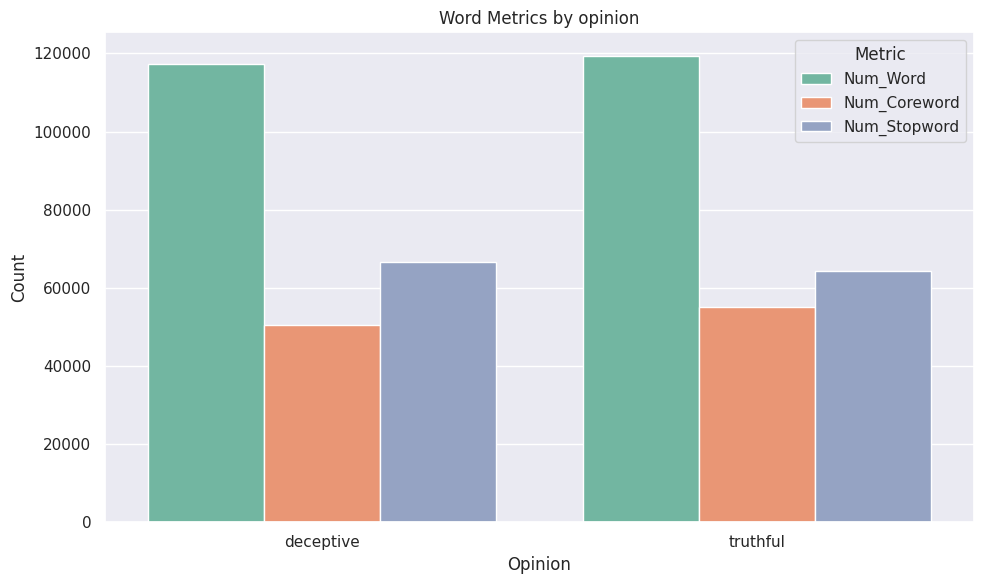

--------------------
Naive Bayes modeling operation in progress . . 
--------------------

=== Independent Opinion and Polarity Classification ===

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Review,Predicted Opinion,Predicted Polarity
0,Two main issues: (1) understaffed from the str...,truthful,negative
1,It's so frustrating when a hotel posts a deal ...,truthful,negative
2,Very centrally located in the Loop directly so...,truthful,positive
3,I enjoyed my stay at the Ambassador East Hotel...,deceptive,positive
4,WARNING! My stay at the Talbott Hotel will go ...,deceptive,negative


Accuracy (Opinion): 0.865625
Accuracy (Polarity): 0.940625


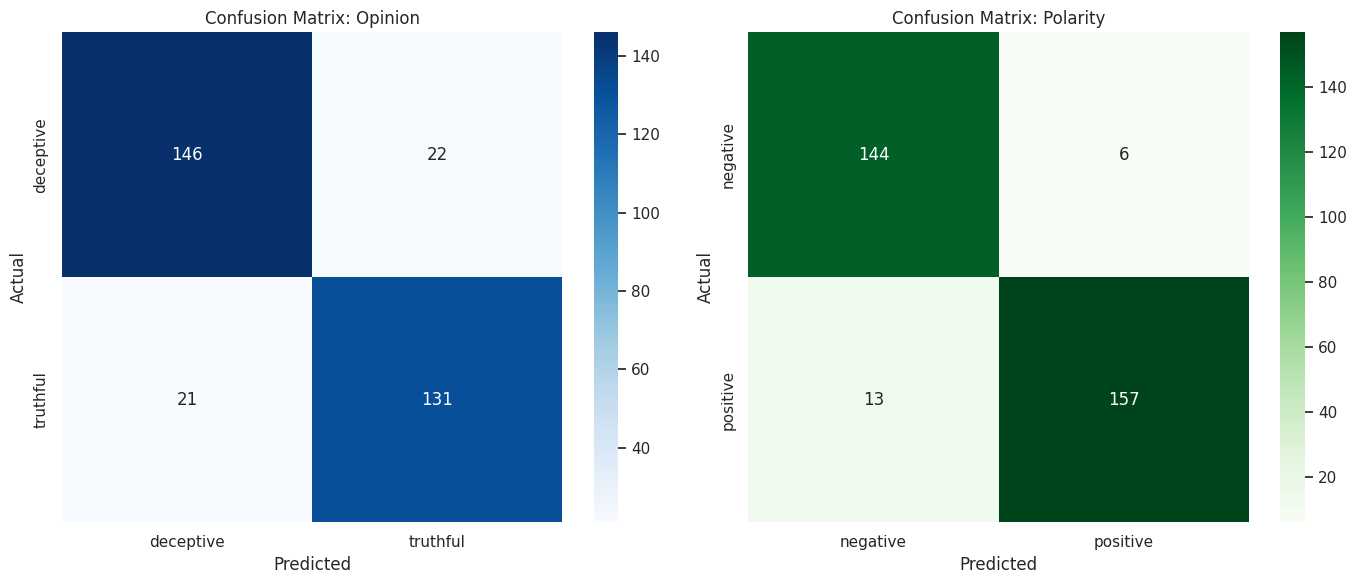


=== Combined Opinion+Polarity Classification ===

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'nb__alpha': 0.1, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.8406
Classification Report:
                     precision    recall  f1-score   support

deceptive_negative       0.80      0.86      0.83        80
deceptive_positive       0.91      0.91      0.91        88
 truthful_negative       0.78      0.74      0.76        70
 truthful_positive       0.86      0.83      0.84        82

          accuracy                           0.84       320
         macro avg       0.84      0.84      0.84       320
      weighted avg       0.84      0.84      0.84       320



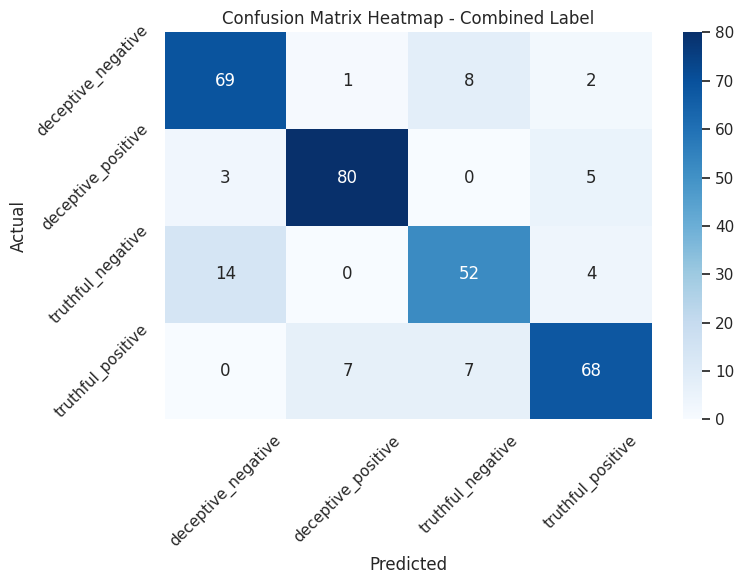

--------------------
Naive Bayes modeling operation done. 
--------------------
--------------------
Logistic Regression modeling operation in progress . . 
--------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters (Multi-output): {'clf__estimator__C': 10, 'clf__estimator__solver': 'liblinear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

--- Multi-output Classification Reports ---

Opinion:
              precision    recall  f1-score   support

   deceptive       0.90      0.88      0.89       168
    truthful       0.87      0.89      0.88       152

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.88       320
weighted avg       0.88      0.88      0.88       320


Polarity:
              precision    recall  f1-score   support

    negative       0.91      0.96      0.93       150
    positive       0.96      0.91      0.94       170

    accuracy                           0.93  

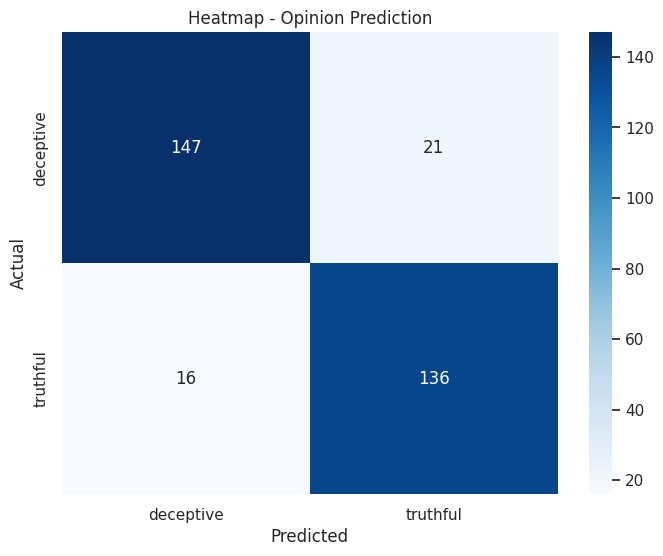

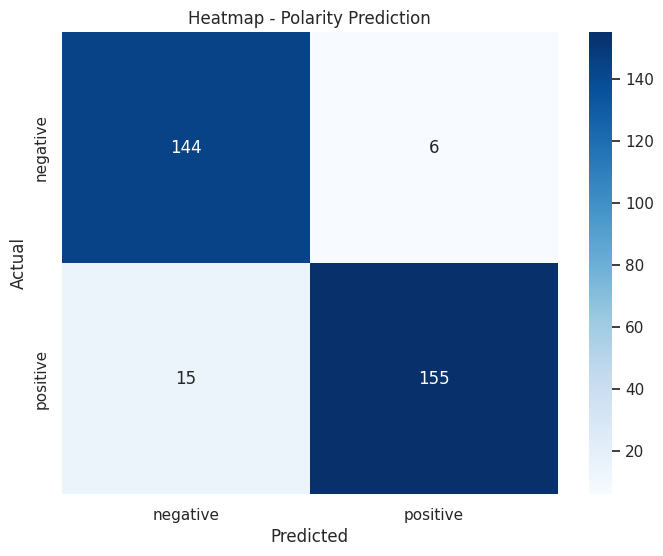

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters (Combined): {'clf__C': 10, 'clf__solver': 'liblinear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

--- Combined Label Classification Report ---
              precision    recall  f1-score   support

         0_0       0.81      0.89      0.85        80
         0_1       0.92      0.86      0.89        88
         1_0       0.81      0.77      0.79        70
         1_1       0.84      0.84      0.84        82

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.85      0.84      0.84       320

Accuracy (Combined Label): 0.84375


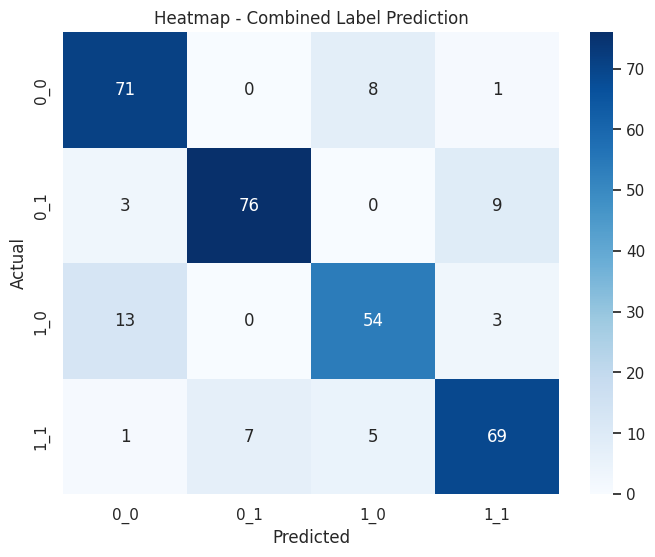

--------------------
Logistic Regression modeling operation done. 
--------------------
--------------------
SVM modeling operation in progress . . 
--------------------

=== Independent Opinion and Polarity Classification (SVM) ===

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Review,Predicted Opinion,Predicted Polarity
0,Two main issues: (1) understaffed from the str...,truthful,negative
1,It's so frustrating when a hotel posts a deal ...,truthful,negative
2,Very centrally located in the Loop directly so...,truthful,negative
3,I enjoyed my stay at the Ambassador East Hotel...,truthful,negative
4,WARNING! My stay at the Talbott Hotel will go ...,truthful,negative


Accuracy (Opinion): 0.478125
Accuracy (Polarity): 0.471875


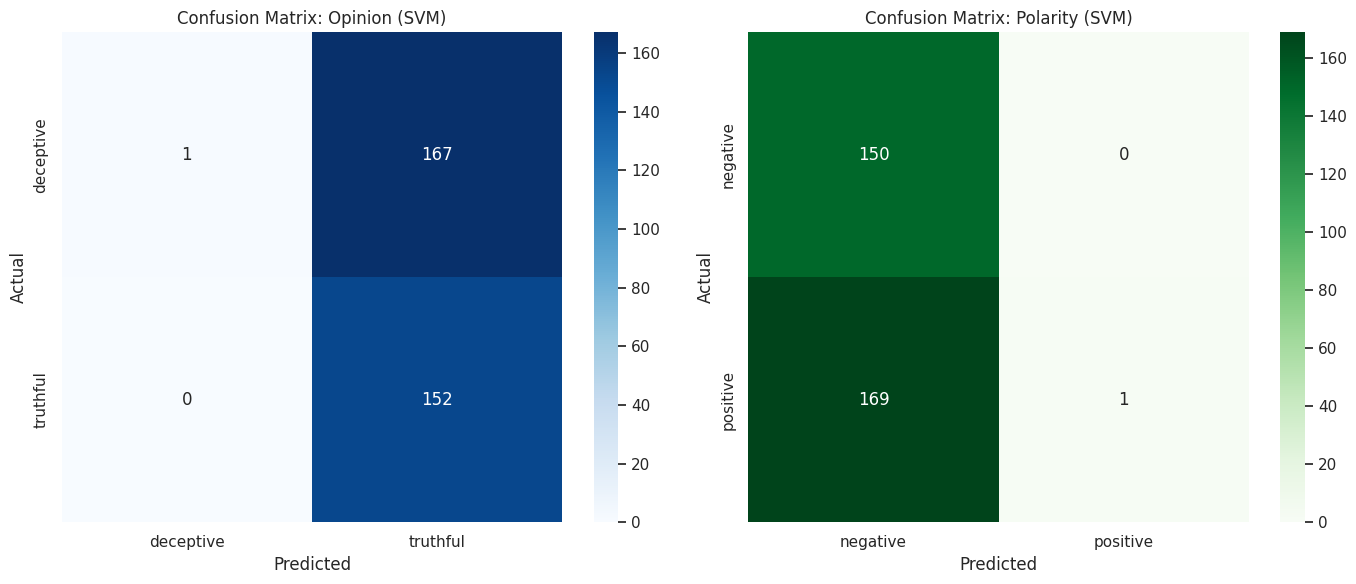


=== Combined Opinion+Polarity Classification (SVM) ===

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'svm__C': 0.1, 'svm__loss': 'squared_hinge', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.7875
Classification Report:
                     precision    recall  f1-score   support

deceptive_negative       0.74      0.80      0.77        80
deceptive_positive       0.88      0.83      0.85        88
 truthful_negative       0.69      0.69      0.69        70
 truthful_positive       0.84      0.82      0.83        82

          accuracy                           0.79       320
         macro avg       0.78      0.78      0.78       320
      weighted avg       0.79      0.79      0.79       320



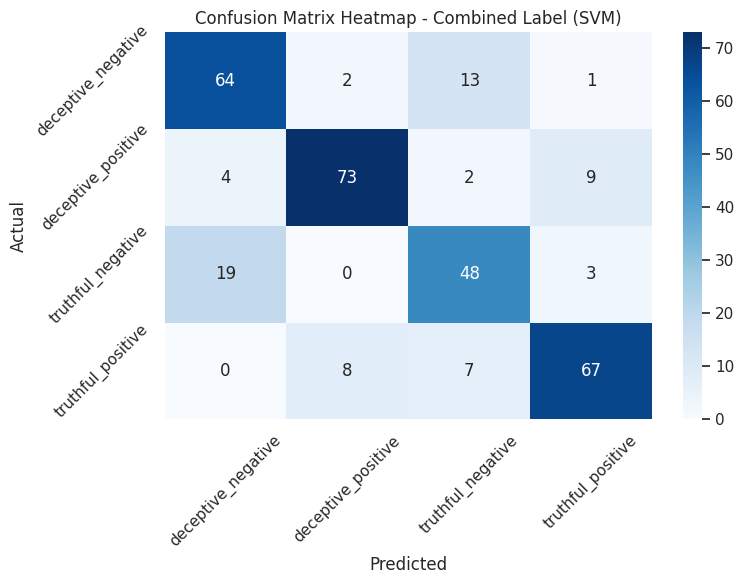

--------------------
SVM modeling operation done. 
--------------------

Results :  [{'model_name': 'ML-LR', 'accuracy': 0.84375, 'model_file_name': '/content/drive/My Drive/pkl folder/combined_lr_model.pkl', 'tf_idf_model_name': '/content/drive/My Drive/pkl folder/lr_combined_tfidf_vectorizer.pkl'}, {'model_name': 'ML-NB', 'accuracy': 0.840625, 'model_file_name': '/content/drive/My Drive/pkl folder/combined_nb_model.pkl', 'tf_idf_model_name': '/content/drive/My Drive/pkl folder/combined_tfidf_vectorizer.pkl'}, {'model_name': 'ML-SVM', 'accuracy': 0.7875, 'model_file_name': '/content/drive/My Drive/pkl folder/combined_svm_model.pkl', 'tf_idf_model_name': '/content/drive/My Drive/pkl folder/combined_svm_tfidf_vectorizer.pkl'}]

Best Model Summary
Model Name: ML-LR
Accuracy: 0.8438
Model File: /content/drive/My Drive/pkl folder/combined_lr_model.pkl
TF IDF Model File: /content/drive/My Drive/pkl folder/lr_combined_tfidf_vectorizer.pkl
✅ Moved best model and TF-IDF vectorizer to: /content

In [ ]:
if __name__ == "__main__":
  run()

In [ ]:
!pip install -q streamlit
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
changed 22 packages in 3s
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

In [ ]:
!streamlit run app.py {model} &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

104.196.22.105
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼your url is: https://upset-rules-strive.loca.lt
